## 1. Standard Imports

In [1]:
# For Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 2. Create the Data

In [7]:
nimages = 3000
imgSize = 64

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
# 1 : Single channel (grey scale image), (64x64 : heightxwidth)
images = torch.zeros(nimages,1,imgSize,imgSize)

for i in range(nimages):

    # create the gaussian with random centers
    
    # ro = random offset
    ro = 2*np.random.randn(2) 
    
    # random width
    width = np.random.rand()/.6 + 1.8   
    G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

    # and add noise
    G  = G + np.random.randn(imgSize,imgSize)/5

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

#### Visualization

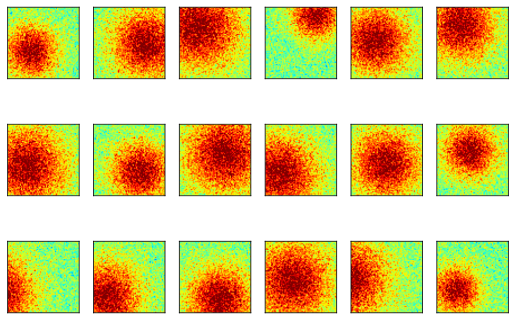

In [9]:
# visualize some images
fig,axs = plt.subplots(3,6, figsize=(9,6), dpi=135)

for i,ax in enumerate(axs.flatten()):
    
    whichpic = np.random.randint(nimages)
    
    G = np.squeeze( images[whichpic,:,:] )
    
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 3. Create Custom classes

In [ ]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

### (i) Discriminator class

In [19]:
class discriminatorNet(nn.Module):
    
    def __init__(self,Print=False):
        
        super().__init__()
        self.print = Print
        # convolution layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)

        # batchnorm
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
    
    def forward(self,x):
        
        if self.print: print(x.shape)
        x = F.leaky_relu( self.conv1(x), negative_slope=.2)
        
        if self.print : print(x.shape)
        x = F.leaky_relu( self.conv2(x) ,.2)
        if self.print : print(x.shape)
        x = self.bn2(x)
        
        x = F.leaky_relu( self.conv3(x) ,.2)
        if self.print: print(x.shape)
        x = self.bn3(x)
        
        x = F.leaky_relu( self.conv4(x) ,.2)
        if self.print :print(x.shape)
        x = self.bn4(x)
        
        x = self.conv5(x)
        if self.print : print(x.shape)
        if self.print: print(x)
        
        return torch.sigmoid( x ).view(-1,1)

#### Testing

In [20]:
dnet = discriminatorNet(Print=True)
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1, 64, 64])
torch.Size([10, 64, 32, 32])
torch.Size([10, 128, 16, 16])
torch.Size([10, 256, 8, 8])
torch.Size([10, 512, 4, 4])
torch.Size([10, 1, 1, 1])
tensor([[[[ 0.6919]]],


        [[[ 0.2443]]],


        [[[-0.1395]]],


        [[[-0.1994]]],


        [[[-0.2649]]],


        [[[-0.2580]]],


        [[[ 0.2994]]],


        [[[-0.9669]]],


        [[[-1.8511]]],


        [[[ 0.0141]]]], grad_fn=<ConvolutionBackward0>)


torch.Size([10, 1])

### (ii) Generator class

In [22]:
class generatorNet(nn.Module):
    
    def __init__(self, Print=False):
        super().__init__()
        
        self.print = Print
        # convolution layers
        self.conv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

        # batchnorm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d( 64)


    def forward(self,x):
        
        if self.print: print(x.shape)
        x = F.relu( self.bn1(self.conv1(x)) )
        
        if self.print: print(x.shape)
        x = F.relu( self.bn2(self.conv2(x)) )
        if self.print: print(x.shape)
        
        x = F.relu( self.bn3(self.conv3(x)) )
        if self.print: print(x.shape)
        
        x = F.relu( self.bn4(self.conv4(x)) )
        if self.print: print(x.shape)
        
        x = torch.tanh( self.conv5(x) )
        if self.print: print(x.shape)
        if self.print: print(x)
            
        return x
    

torch.Size([10, 100, 1, 1])
torch.Size([10, 512, 4, 4])
torch.Size([10, 256, 8, 8])
torch.Size([10, 128, 16, 16])
torch.Size([10, 64, 32, 32])
torch.Size([10, 1, 64, 64])
tensor([[[[-0.2851,  0.0057, -0.2535,  ..., -0.4375, -0.5061, -0.2871],
          [-0.2423,  0.5323,  0.7417,  ..., -0.4447, -0.3814,  0.3324],
          [ 0.5622, -0.3943,  0.7609,  ..., -0.9089,  0.6558, -0.2224],
          ...,
          [-0.4891, -0.1527,  0.1782,  ...,  0.3579,  0.6008, -0.3566],
          [ 0.6917, -0.7902,  0.2818,  ..., -0.0317, -0.1183, -0.3521],
          [ 0.2495, -0.6704,  0.3288,  ..., -0.5000, -0.4082, -0.0752]]],


        [[[-0.0837,  0.1568, -0.5242,  ..., -0.2352, -0.1547, -0.2970],
          [-0.3729,  0.1753, -0.0014,  ..., -0.4303, -0.7756, -0.0820],
          [ 0.7326, -0.2578,  0.4673,  ..., -0.5496,  0.4680, -0.3647],
          ...,
          [-0.4202, -0.2363, -0.3912,  ...,  0.0160,  0.2448, -0.4598],
          [ 0.3129, -0.5359,  0.6454,  ..., -0.4051,  0.9396, -0.3395],
   

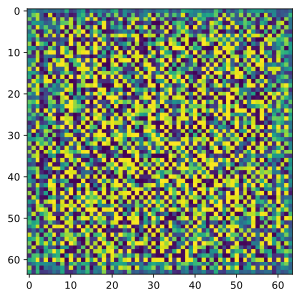

In [23]:
gnet = generatorNet(Print=True)

y = gnet(torch.randn(10,100,1,1))
# print(y.shape)

plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

## 4. Train the models

### (i) Loss Function , model instances and Optimizers

In [ ]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet(Print=False)
gnet = generatorNet(Print=False)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

### (ii) Model Training 